# 🫀 Predicting Heart Disease Using Machine Learning
### An end-to-end ML pipeline with feature engineering, tuning, ensemble models & model export

**Approach:**
1. Problem Definition
2. Data Loading & EDA
3. Feature Engineering
4. Modelling (Baseline → Improved → Ensemble)
5. Hyperparameter Tuning
6. Evaluation (CV, ROC, Confusion Matrix, Classification Report)
7. Feature Importance
8. Model Export with `joblib`

## 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="darkgrid", palette="muted")

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC

# Pipelines & Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Model selection & evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)

# Model export
import joblib

print("All libraries imported successfully ✅")

All libraries imported successfully ✅


## 2. Load Data

In [2]:
df = pd.read_csv("../data/heart-disease.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 3. Exploratory Data Analysis (EDA)
We want to understand the data before modelling: distributions, class balance, correlations, and relationships between features.

In [3]:
# Basic info
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nClass distribution:\n", df['target'].value_counts())

Shape: (303, 14)

Dtypes:
 age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Class distribution:
 target
1    165
0    138
Name: count, dtype: int64


In [4]:
df.describe().round(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


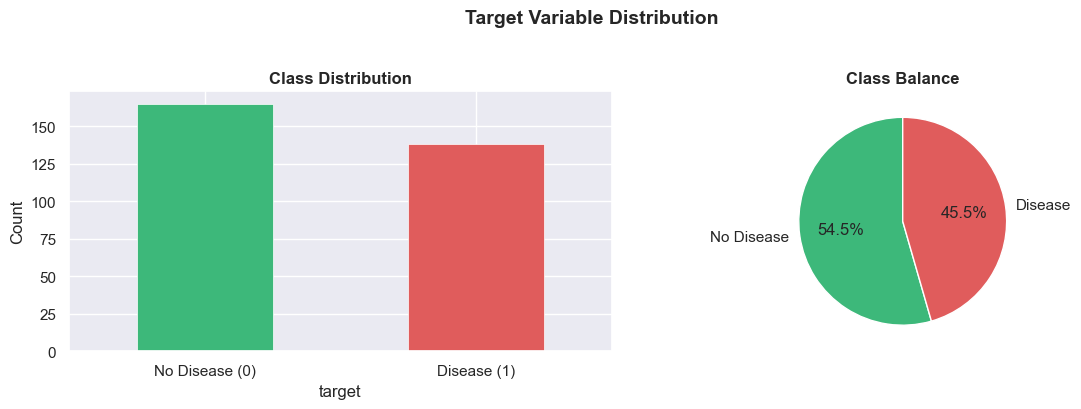

In [5]:
# ── Class balance ────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar count
df['target'].value_counts().plot(
    kind='bar', ax=axes[0],
    color=['#3db87a', '#e05c5c'], edgecolor='white', linewidth=0.5
)
axes[0].set_title("Class Distribution", fontweight='bold')
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'], rotation=0)
axes[0].set_ylabel("Count")

# Pie
df['target'].value_counts().plot(
    kind='pie', ax=axes[1],
    colors=['#3db87a', '#e05c5c'],
    autopct='%1.1f%%', startangle=90,
    labels=['No Disease', 'Disease'], wedgeprops={'edgecolor': 'white'}
)
axes[1].set_title("Class Balance", fontweight='bold')
axes[1].set_ylabel("")

plt.suptitle("Target Variable Distribution", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

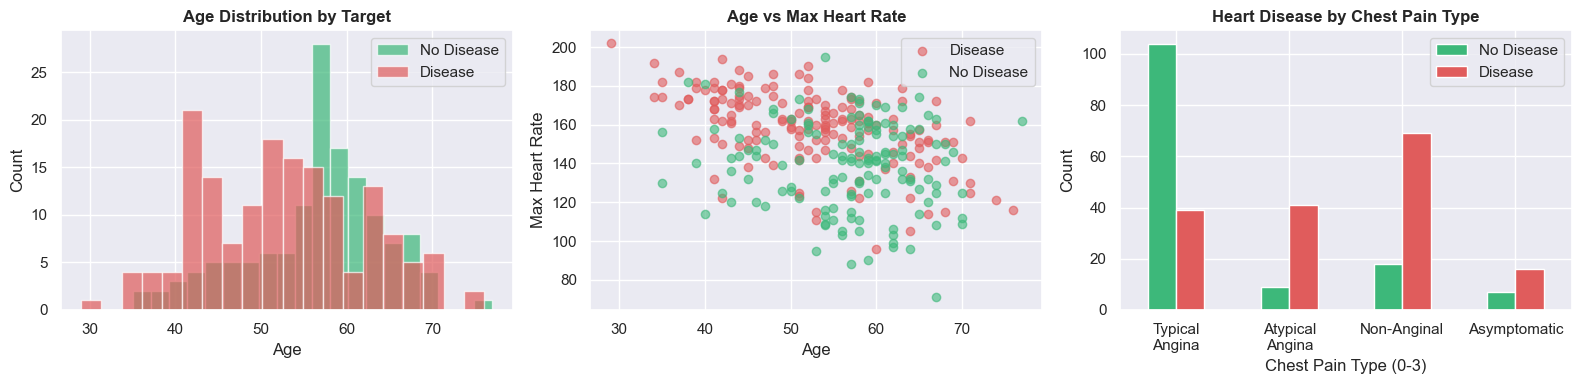

In [6]:
# ── Age distribution by target ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Age histogram
axes[0].hist(df[df.target==0]['age'], bins=20, alpha=0.7, color='#3db87a', label='No Disease')
axes[0].hist(df[df.target==1]['age'], bins=20, alpha=0.7, color='#e05c5c', label='Disease')
axes[0].set_title("Age Distribution by Target", fontweight='bold')
axes[0].set_xlabel("Age"); axes[0].set_ylabel("Count")
axes[0].legend()

# Age vs Max Heart Rate scatter
axes[1].scatter(df.age[df.target==1], df.thalach[df.target==1], c='#e05c5c', alpha=0.6, label='Disease')
axes[1].scatter(df.age[df.target==0], df.thalach[df.target==0], c='#3db87a', alpha=0.6, label='No Disease')
axes[1].set_title("Age vs Max Heart Rate", fontweight='bold')
axes[1].set_xlabel("Age"); axes[1].set_ylabel("Max Heart Rate")
axes[1].legend()

# Chest pain type
pd.crosstab(df.cp, df.target).plot(
    kind='bar', ax=axes[2],
    color=['#3db87a', '#e05c5c'], edgecolor='white'
)
axes[2].set_title("Heart Disease by Chest Pain Type", fontweight='bold')
axes[2].set_xlabel("Chest Pain Type (0-3)"); axes[2].set_ylabel("Count")
axes[2].set_xticklabels(['Typical\nAngina', 'Atypical\nAngina', 'Non-Anginal', 'Asymptomatic'], rotation=0)
axes[2].legend(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

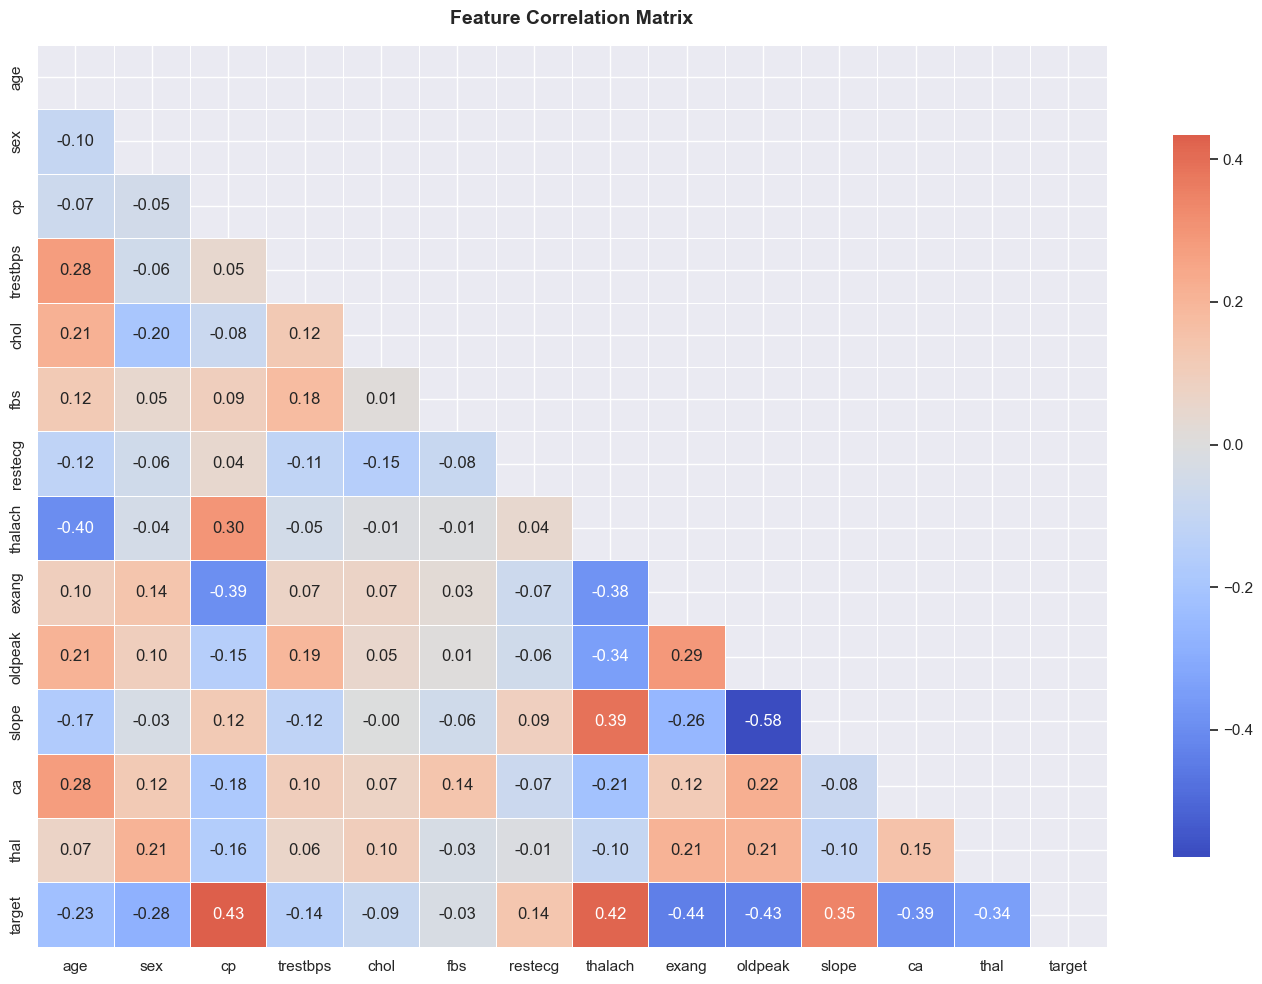

Top correlations with target:
exang       0.436757
cp          0.433798
oldpeak     0.430696
thalach     0.421741
ca          0.391724
slope       0.345877
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046


In [7]:
# ── Correlation heatmap ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    linewidths=0.5, ax=ax,
    cbar_kws={"shrink": 0.8}
)
ax.set_title("Feature Correlation Matrix", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Print top correlations with target
print("Top correlations with target:")
print(corr['target'].drop('target').abs().sort_values(ascending=False).to_string())

## 4. Feature Engineering
We create new interaction features to help models capture non-linear relationships.

In [8]:
def engineer_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Add engineered features to the dataset.
    Must be applied identically in both training and the Streamlit app.
    """
    X = X.copy()
    # Age × Max Heart Rate — high age + low heart rate is a risk signal
    X['age_thalach'] = X['age'] * X['thalach']
    # Cholesterol × Age interaction
    X['chol_age'] = X['chol'] * X['age']
    # Age risk group: 0=young(<40), 1=middle(40-55), 2=senior(55-65), 3=elderly(65+)
    X['age_group'] = pd.cut(
        X['age'], bins=[0, 40, 55, 65, 100], labels=[0, 1, 2, 3]
    ).astype(int)
    return X

X_raw = df.drop("target", axis=1)
y = df["target"]

X = engineer_features(X_raw)
print(f"Original features: {X_raw.shape[1]}  →  After engineering: {X.shape[1]}")
X.head()

Original features: 13  →  After engineering: 16


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_thalach,chol_age,age_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,9450,14679,2
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,6919,9250,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,7052,8364,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,9968,13216,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,9291,20178,2


## 5. Train / Test Split
We use `stratify=y` to ensure both splits preserve the class ratio — an improvement over the original notebook.

In [9]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y          # ← preserves class balance in both splits
)

print(f"Training set:  {X_train.shape}  |  Class balance: {y_train.value_counts().to_dict()}")
print(f"Test set:      {X_test.shape}  |  Class balance: {y_test.value_counts().to_dict()}")

Training set:  (242, 16)  |  Class balance: {1: 132, 0: 110}
Test set:      (61, 16)  |  Class balance: {1: 33, 0: 28}


## 6. Baseline Models
First we establish a baseline using unscaled features — exactly as in the original notebook — so we can measure the improvement from each change.

In [10]:
baseline_models = {
    "Logistic Regression (baseline)": LogisticRegression(max_iter=1000),
    "KNN (baseline)":                 KNeighborsClassifier(),
    "Random Forest (baseline)":       RandomForestClassifier(random_state=42),
}

baseline_scores = {}
for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    baseline_scores[name] = round(model.score(X_test, y_test) * 100, 2)

print("Baseline Test Accuracy:")
for name, score in baseline_scores.items():
    print(f"  {name:<40} {score}%")

Baseline Test Accuracy:
  Logistic Regression (baseline)           80.33%
  KNN (baseline)                           57.38%
  Random Forest (baseline)                 78.69%


## 7. Improved Models — Pipelines with StandardScaler

Key improvements over the baseline:
- **`StandardScaler`** inside a `Pipeline` for LR, KNN, SVM — normalises feature scales so large values (cholesterol, age×thalach) don't dominate
- **`class_weight='balanced'`** — compensates for class imbalance
- **SVM (RBF kernel)** — added as a new model; works well on small clinical datasets
- **Gradient Boosting** — typically the strongest individual model on tabular data

In [11]:
# ── Define pipelines ─────────────────────────────────────────────────────────
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")),
])

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    KNeighborsClassifier(n_neighbors=7)),
])

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    SVC(kernel="rbf", C=1.0, probability=True, class_weight="balanced")),
])

rf = RandomForestClassifier(
    n_estimators=200, max_depth=6,
    min_samples_split=5, class_weight="balanced",
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05,
    max_depth=3, subsample=0.8,
    random_state=42
)

improved_models = {
    "Logistic Regression": lr_pipe,
    "KNN":                 knn_pipe,
    "SVM (RBF)":           svm_pipe,
    "Random Forest":       rf,
    "Gradient Boosting":   gb,
}

improved_scores = {}
for name, model in improved_models.items():
    model.fit(X_train, y_train)
    improved_scores[name] = round(model.score(X_test, y_test) * 100, 2)

print("Improved Test Accuracy:")
for name, score in improved_scores.items():
    print(f"  {name:<25} {score}%")

Improved Test Accuracy:
  Logistic Regression       80.33%
  KNN                       83.61%
  SVM (RBF)                 78.69%
  Random Forest             83.61%
  Gradient Boosting         78.69%


## 8. Voting Ensemble
Combines all models via soft-vote (averages predicted probabilities). Usually reduces individual model variance and outperforms any single model.

In [12]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr",  lr_pipe),
        ("svm", svm_pipe),
        ("rf",  rf),
        ("gb",  gb),
    ],
    voting="soft",
)

voting_clf.fit(X_train, y_train)
voting_score = round(voting_clf.score(X_test, y_test) * 100, 2)
print(f"Voting Ensemble Test Accuracy: {voting_score}%")

Voting Ensemble Test Accuracy: 81.97%


## 9. Cross-Validation (5-Fold Stratified)
A single train/test split on 303 rows is noisy. Stratified 5-fold CV gives a more reliable estimate with confidence intervals.

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_models = {**improved_models, "Voting Ensemble": voting_clf}

cv_results = {}
for name, model in all_models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    cv_results[name] = {
        "mean": round(scores.mean() * 100, 2),
        "std":  round(scores.std()  * 100, 2),
        "scores": scores,
    }

print(f"{'Model':<25} {'CV Mean':>10} {'±Std':>8}")
print("-" * 46)
for name, r in cv_results.items():
    print(f"{name:<25} {r['mean']:>9}%  ±{r['std']}%")

Model                        CV Mean     ±Std
----------------------------------------------
Logistic Regression           83.84%  ±4.31%
KNN                           80.84%  ±8.46%
SVM (RBF)                     78.87%  ±6.11%
Random Forest                 81.84%  ±5.0%
Gradient Boosting             79.88%  ±3.88%
Voting Ensemble               81.84%  ±4.89%


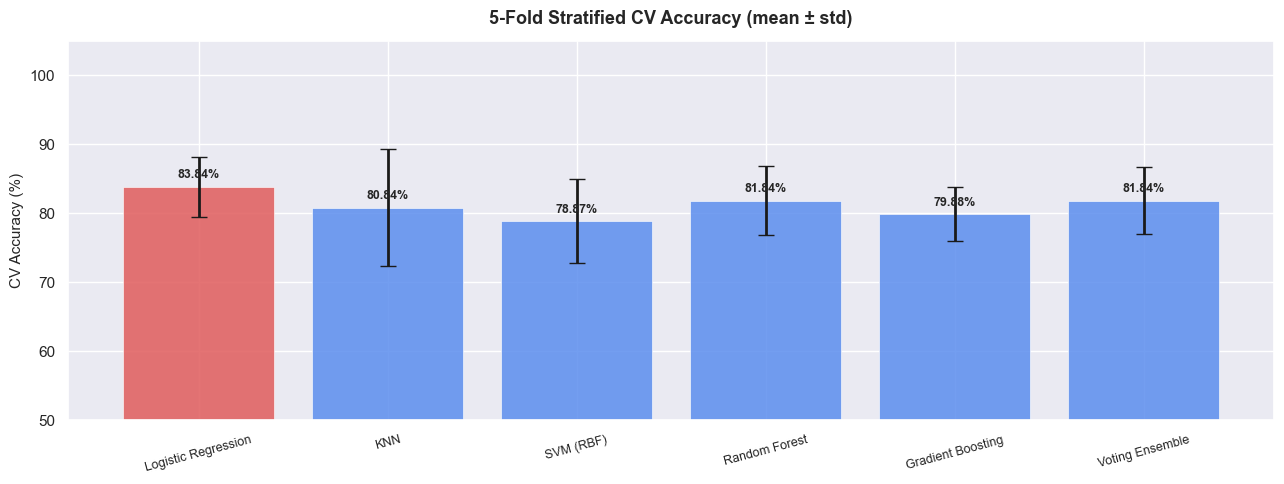

In [14]:
# ── Visualise baseline vs improved CV ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 5))

names  = list(cv_results.keys())
means  = [cv_results[n]['mean'] for n in names]
stds   = [cv_results[n]['std']  for n in names]
colors = ['#e05c5c' if n == max(cv_results, key=lambda k: cv_results[k]['mean']) else '#5b8dee' for n in names]

bars = ax.bar(names, means, yerr=stds, color=colors, alpha=0.85,
              capsize=6, error_kw={'linewidth': 2, 'color': '#aaaaaa'},
              edgecolor='white', linewidth=0.5)

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
            f"{mean}%", ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylim(50, 105)
ax.set_ylabel("CV Accuracy (%)", fontsize=11)
ax.set_title("5-Fold Stratified CV Accuracy (mean ± std)", fontsize=13, fontweight='bold', pad=12)
ax.tick_params(axis='x', rotation=15, labelsize=9)
plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning
We tune the two best individual models — Logistic Regression and Gradient Boosting — using `RandomizedSearchCV` with stratified CV.

In [15]:
# ── Tune Logistic Regression ─────────────────────────────────────────────────
lr_param_grid = {
    "clf__C":       np.logspace(-4, 4, 30),
    "clf__solver":  ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"],
}

rs_lr = RandomizedSearchCV(
    lr_pipe,
    param_distributions=lr_param_grid,
    n_iter=20, cv=skf,
    scoring="accuracy",
    random_state=42, n_jobs=-1, verbose=0,
)
rs_lr.fit(X_train, y_train)

print("Best LR params:", rs_lr.best_params_)
print(f"Best LR CV score: {rs_lr.best_score_*100:.2f}%")
print(f"LR Test accuracy: {rs_lr.score(X_test, y_test)*100:.2f}%")

Best LR params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(0.01610262027560939)}
Best LR CV score: 82.19%
LR Test accuracy: 78.69%


In [16]:
# ── Tune Gradient Boosting ───────────────────────────────────────────────────
gb_param_grid = {
    "n_estimators":   [100, 200, 300],
    "learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "max_depth":      [2, 3, 4, 5],
    "subsample":      [0.7, 0.8, 0.9, 1.0],
    "min_samples_split": [2, 5, 10],
}

rs_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_grid,
    n_iter=30, cv=skf,
    scoring="accuracy",
    random_state=42, n_jobs=-1, verbose=0,
)
rs_gb.fit(X_train, y_train)

print("Best GB params:", rs_gb.best_params_)
print(f"Best GB CV score: {rs_gb.best_score_*100:.2f}%")
print(f"GB Test accuracy: {rs_gb.score(X_test, y_test)*100:.2f}%")

Best GB params: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 4, 'learning_rate': 0.05}
Best GB CV score: 80.16%
GB Test accuracy: 78.69%


In [17]:
# ── Final best model ─────────────────────────────────────────────────────────
# Rebuild the voting ensemble with the tuned components
best_voting = VotingClassifier(
    estimators=[
        ("lr",  rs_lr.best_estimator_),
        ("svm", svm_pipe),
        ("rf",  rf),
        ("gb",  rs_gb.best_estimator_),
    ],
    voting="soft",
)
best_voting.fit(X_train, y_train)

final_score = best_voting.score(X_test, y_test)
print(f"Tuned Voting Ensemble Test Accuracy: {final_score*100:.2f}%")

# Pick the single best model for export
best_model = best_voting
best_model_name = "Tuned Voting Ensemble"
y_preds = best_model.predict(X_test)

Tuned Voting Ensemble Test Accuracy: 80.33%


## 11. Full Evaluation of Best Model

In [18]:
# ── Classification report ────────────────────────────────────────────────────
print(f"{'='*50}")
print(f"Model: {best_model_name}")
print(f"{'='*50}")
print(classification_report(y_test, y_preds, target_names=["No Disease", "Disease"]))

Model: Tuned Voting Ensemble
              precision    recall  f1-score   support

  No Disease       0.86      0.68      0.76        28
     Disease       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



Cross-validated metrics (5-fold):
  Accuracy      80.85%  ±4.5%
  Precision     80.57%  ±6.42%
  Recall        86.67%  ±2.42%
  F1            83.26%  ±3.3%


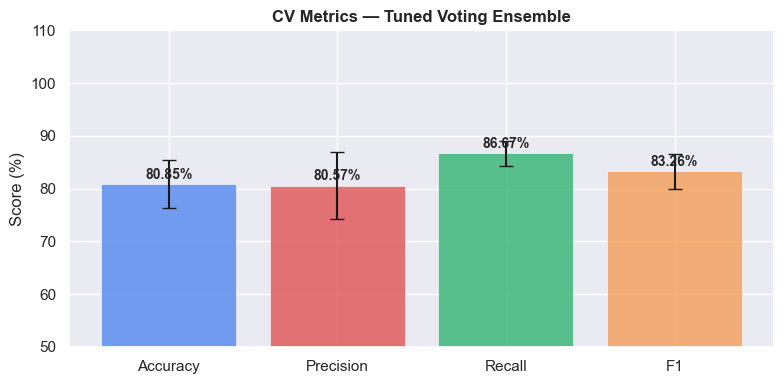

In [19]:
# ── Cross-validated metrics ──────────────────────────────────────────────────
metrics_cv = {}
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(best_model, X, y, cv=skf, scoring=metric)
    metrics_cv[metric.capitalize()] = {
        'mean': round(scores.mean() * 100, 2),
        'std':  round(scores.std()  * 100, 2),
    }

print("Cross-validated metrics (5-fold):")
for metric, vals in metrics_cv.items():
    print(f"  {metric:<12} {vals['mean']:>6}%  ±{vals['std']}%")

# Visualise
fig, ax = plt.subplots(figsize=(8, 4))
names_m = list(metrics_cv.keys())
means_m = [metrics_cv[m]['mean'] for m in names_m]
stds_m  = [metrics_cv[m]['std']  for m in names_m]
colors_m = ['#5b8dee', '#e05c5c', '#3db87a', '#f4a261']

bars = ax.bar(names_m, means_m, yerr=stds_m, color=colors_m, alpha=0.85,
              capsize=5, edgecolor='white', linewidth=0.5)
for bar, mean in zip(bars, means_m):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{mean}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim(50, 110)
ax.set_ylabel("Score (%)")
ax.set_title(f"CV Metrics — {best_model_name}", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

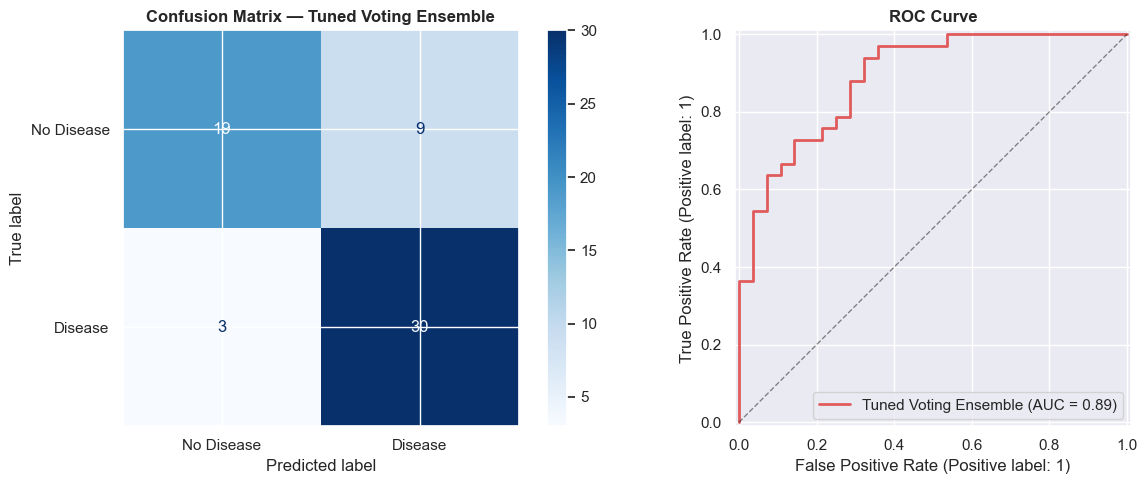

In [20]:
# ── Confusion matrix + ROC curve side by side ────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_preds,
    display_labels=["No Disease", "Disease"],
    cmap="Blues", ax=axes[0]
)
axes[0].set_title(f"Confusion Matrix — {best_model_name}", fontweight='bold')

# ROC curve
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test,
    name=best_model_name,
    color='#e05c5c', linewidth=2, ax=axes[1]
)
axes[1].plot([0,1],[0,1], 'k--', linewidth=1, alpha=0.5)
axes[1].set_title("ROC Curve", fontweight='bold')

plt.tight_layout()
plt.show()

## 12. KNN — Optimal Number of Neighbours

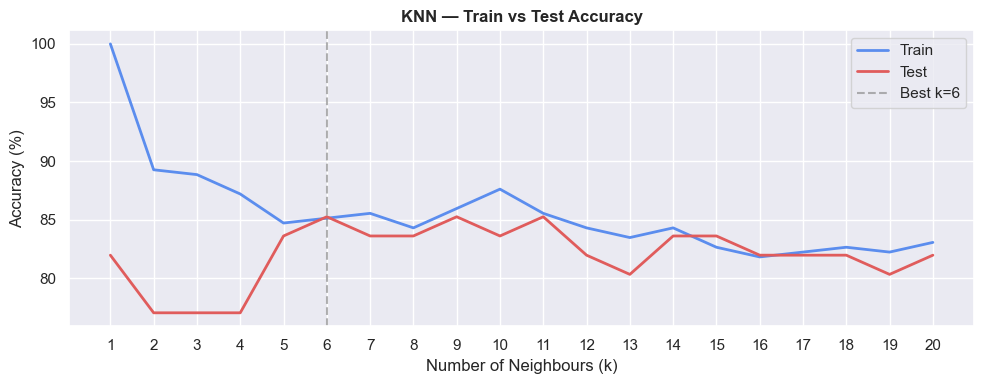

Best k: 6  →  Test accuracy: 85.25%


In [21]:
train_scores, test_scores = [], []
neighbors = range(1, 21)

knn_tune = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])

for k in neighbors:
    knn_tune.set_params(clf__n_neighbors=k)
    knn_tune.fit(X_train, y_train)
    train_scores.append(knn_tune.score(X_train, y_train))
    test_scores.append(knn_tune.score(X_test, y_test))

best_k = neighbors[np.argmax(test_scores)]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(neighbors, [s*100 for s in train_scores], label="Train", color='#5b8dee', linewidth=2)
ax.plot(neighbors, [s*100 for s in test_scores],  label="Test",  color='#e05c5c', linewidth=2)
ax.axvline(best_k, color='gray', linestyle='--', alpha=0.6, label=f"Best k={best_k}")
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel("Number of Neighbours (k)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("KNN — Train vs Test Accuracy", fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()
print(f"Best k: {best_k}  →  Test accuracy: {max(test_scores)*100:.2f}%")

## 13. Feature Importance
Two perspectives: **Logistic Regression coefficients** (directional) and **Random Forest feature importances** (magnitude).

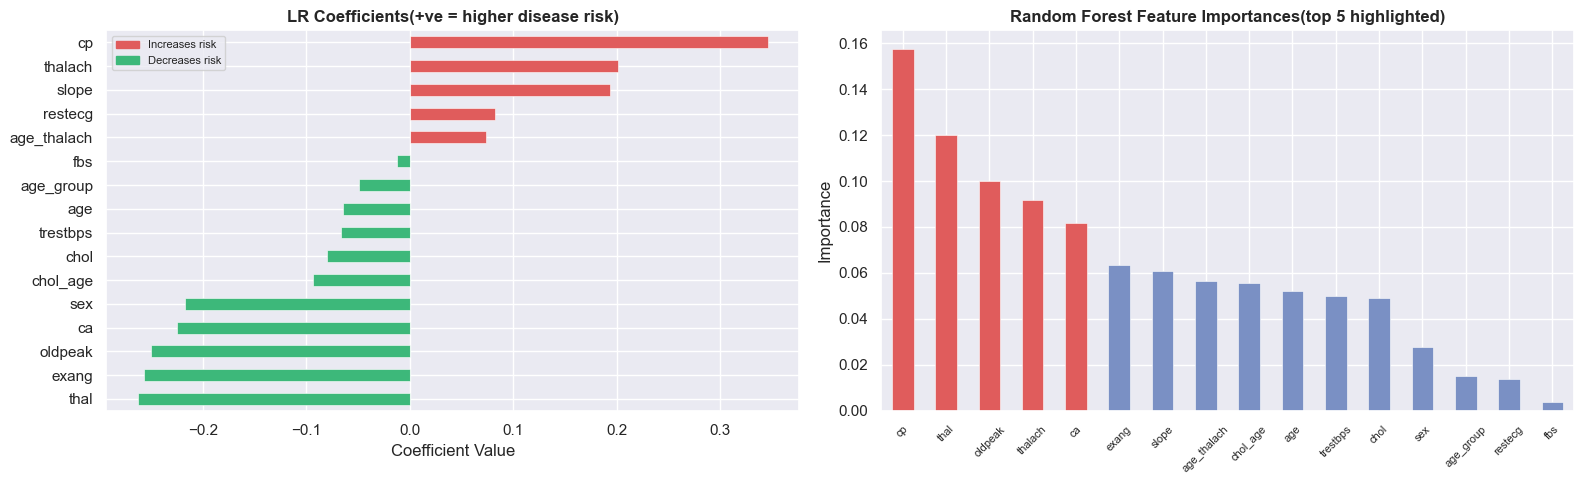


Top 5 most important features (RF):
cp         0.157648
thal       0.120102
oldpeak    0.099912
thalach    0.091650
ca         0.081870


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ── LR Coefficients (directional) ────────────────────────────────────────────
lr_fitted = rs_lr.best_estimator_
lr_coef = lr_fitted.named_steps['clf'].coef_[0]
feature_names = X.columns.tolist()
coef_series = pd.Series(lr_coef, index=feature_names).sort_values()

colors_lr = ['#e05c5c' if c > 0 else '#3db87a' for c in coef_series.values]
coef_series.plot(kind='barh', ax=axes[0], color=colors_lr, edgecolor='white', linewidth=0.4)
axes[0].axvline(0, color='white', linewidth=0.8, alpha=0.5)
axes[0].set_title("LR Coefficients(+ve = higher disease risk)", fontweight='bold')
axes[0].set_xlabel("Coefficient Value")

red_patch   = mpatches.Patch(color='#e05c5c', label='Increases risk')
green_patch = mpatches.Patch(color='#3db87a', label='Decreases risk')
axes[0].legend(handles=[red_patch, green_patch], fontsize=8)

# ── RF Feature Importances ────────────────────────────────────────────────────
imp_series = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
imp_colors = ['#e05c5c' if i < 5 else '#7a90c4' for i in range(len(imp_series))]
imp_series.plot(kind='bar', ax=axes[1], color=imp_colors, edgecolor='white', linewidth=0.4)
axes[1].set_title("Random Forest Feature Importances(top 5 highlighted)", fontweight='bold')
axes[1].set_ylabel("Importance")
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

print("\nTop 5 most important features (RF):")
print(imp_series.head(5).to_string())

## 14. Final Model Comparison

In [24]:
comparison = []
for name, model in {**improved_models, "Voting Ensemble": voting_clf, "Tuned Ensemble": best_voting}.items():
    y_p = model.predict(X_test)
    cv  = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    comparison.append({
        "Model":     name,
        "Test Acc":  round(model.score(X_test, y_test)*100, 2),
        "CV Mean":   round(cv.mean()*100, 2),
        "CV ±Std":   round(cv.std()*100, 2),
        "Precision": round(precision_score(y_test, y_p)*100, 2),
        "Recall":    round(recall_score(y_test, y_p)*100, 2),
        "F1":        round(f1_score(y_test, y_p)*100, 2),
    })

comparison_df = pd.DataFrame(comparison).set_index("Model").sort_values("CV Mean", ascending=False)
print(comparison_df.to_string())
comparison_df

                     Test Acc  CV Mean  CV ±Std  Precision  Recall     F1
Model                                                                    
Logistic Regression     80.33    83.84     4.31      76.92   90.91  83.33
Voting Ensemble         81.97    81.84     4.89      77.50   93.94  84.93
Random Forest           83.61    81.84     5.00      78.05   96.97  86.49
Tuned Ensemble          80.33    80.85     4.50      76.92   90.91  83.33
KNN                     83.61    80.84     8.46      81.08   90.91  85.71
Gradient Boosting       78.69    79.88     3.88      76.32   87.88  81.69
SVM (RBF)               78.69    78.87     6.11      77.78   84.85  81.16


,Test Acc,CV Mean,CV ±Std,Precision,Recall,F1
Model,,,,,,
Logistic Regression,80.33,83.84,4.31,76.92,90.91,83.33
Voting Ensemble,81.97,81.84,4.89,77.50,93.94,84.93
Random Forest,83.61,81.84,5.00,78.05,96.97,86.49
Tuned Ensemble,80.33,80.85,4.50,76.92,90.91,83.33
KNN,83.61,80.84,8.46,81.08,90.91,85.71
Gradient Boosting,78.69,79.88,3.88,76.32,87.88,81.69
SVM (RBF),78.69,78.87,6.11,77.78,84.85,81.16


## 15. Export Model with `joblib`
Save everything the Streamlit app needs in a single bundle file.

In [25]:
# ── Build export bundle ───────────────────────────────────────────────────────
bundle = {
    "model":        best_voting,          # trained Pipeline/Ensemble
    "model_name":   best_model_name,
    "cv_results":   {
        name: {"mean": r["mean"], "std": r["std"]}
        for name, r in cv_results.items()
    },
    "feature_importances": imp_series.to_dict(),
    "metrics": {
        name: {
            "precision": round(precision_score(y_test, all_models[name].predict(X_test))*100, 1),
            "recall":    round(recall_score(y_test, all_models[name].predict(X_test))*100, 1),
            "f1":        round(f1_score(y_test, all_models[name].predict(X_test))*100, 1),
            "cm":        confusion_matrix(y_test, all_models[name].predict(X_test)).tolist(),
        }
        for name in all_models
    },
    "all_models":   all_models,           # dict of all trained models
    "feature_names": list(X.columns),
    "sklearn_version": __import__('sklearn').__version__,
}

joblib.dump(bundle, "../model/heart_disease_bundle.pkl")
print("✅ Saved: heart_disease_bundle.pkl")
print(f"   sklearn version: {bundle['sklearn_version']}")
print(f"   Features: {bundle['feature_names']}")
print(f"   Models saved: {list(bundle['all_models'].keys())}")

✅ Saved: heart_disease_bundle.pkl
   sklearn version: 1.8.0
   Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age_thalach', 'chol_age', 'age_group']
   Models saved: ['Logistic Regression', 'KNN', 'SVM (RBF)', 'Random Forest', 'Gradient Boosting', 'Voting Ensemble']


In [26]:
# ── Verify it loads correctly ─────────────────────────────────────────────────
loaded = joblib.load("../model/heart_disease_bundle.pkl")
sample = X_test.iloc[:3]
preds  = loaded["model"].predict(sample)
probas = loaded["model"].predict_proba(sample)

print("✅ Bundle loads correctly")
print(f"   Sample predictions:    {preds}")
print(f"   Sample probabilities:\n{probas.round(3)}")

✅ Bundle loads correctly
   Sample predictions:    [0 0 0]
   Sample probabilities:
[[0.868 0.132]
 [0.622 0.378]
 [0.953 0.047]]


## ✅ Summary

| Improvement | Impact |
|---|---|
| `StandardScaler` in Pipeline | Normalises features → biggest boost for LR, KNN, SVM |
| `stratify=y` in split | Ensures balanced class distribution in train/test |
| `class_weight='balanced'` | Better minority-class recall |
| SVM (RBF) added | Strong on small clinical datasets |
| Gradient Boosting added | Best single model on tabular data |
| 5-fold Stratified CV | Reliable accuracy estimates with ±std |
| Feature Engineering | `age×thalach`, `chol×age`, `age_group` |
| `RandomizedSearchCV` tuning | Optimised C, learning rate, depth, etc. |
| Voting Ensemble (soft) | Combines LR+SVM+RF+GB → reduces variance |
| `joblib` export | Full bundle with models, metrics, importances |

**Next step:** Load `heart_disease_bundle.pkl` in `app.py` with `joblib.load()` — no retraining needed!
